In [6]:
# implement https://arxiv.org/pdf/1705.08690.pdf on avalanche framework on permuted MNIST
# https://aahaanmaini.medium.com/mimicking-human-continual-learning-in-a-neural-network-c15e1ae11d70
#continual learning

## create GAN

In [86]:
%load_ext autoreload
%autoreload 2
from helper_func import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [87]:
#https://github.com/znxlwm/pytorch-MNIST-CelebA-GAN-DCGAN/blob/master/pytorch_MNIST_GAN.py
import matplotlib.pyplot as plt
from torch import nn
#import imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

# G(z)
class generator(nn.Module):
    # initializers
    def __init__(self, input_size=32, n_class = 10):
        super(generator, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, 512)
        self.fc3 = nn.Linear(self.fc2.out_features, 1024)
        self.fc4 = nn.Linear(self.fc3.out_features, n_class)

    # forward method
    def forward(self, input):
        x = F.leaky_relu(self.fc1(input), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.tanh(self.fc4(x))

        return x

class discriminator(nn.Module):
    # initializers
    def __init__(self, input_size=32, n_class=10):
        super(discriminator, self).__init__()
        self.fc1 = nn.Linear(input_size, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, 512)
        self.fc3 = nn.Linear(self.fc2.out_features, 256)
        self.fc4 = nn.Linear(self.fc3.out_features, n_class)

    # forward method
    def forward(self, input):
        x = F.leaky_relu(self.fc1(input), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.sigmoid(self.fc4(x))

        return x


## Neural Network Architecture

In [89]:
from torch.optim import SGD, Adam
from torch.nn import CrossEntropyLoss

#MNIST neural network with 2 hidden layers of 400 neurons each
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 400)
        self.fc2 = nn.Linear(400, 400)
        self.fc3 = nn.Linear(400, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


## naive

In [116]:
model_naive = Net()
optimizer_naive = SGD(model_naive.parameters(), lr=0.001, momentum=0.9)
criterion_naive = CrossEntropyLoss()

naive_accuracies = []
for experience in range(5):
    train_dataset,test_dataset = get_datasets(experience, transform=transform)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)
    for epoch in range(0, 3):
        model_naive.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            #wrap in variable
            data, target = Variable(data), Variable(target)
            optimizer_naive.zero_grad()
            output = model_naive(data)
            loss = criterion_naive(output, target)
            loss.backward()
            optimizer_naive.step()
    
    model_naive.eval()
    accuracy = test_model(model_naive, test_loader)
    print('Experience: {} Accuracy: {:.2f}'.format(experience, accuracy))
    naive_accuracies.append(accuracy)

print(naive_accuracies)



Test Accuracy of the model on the test images: 99.95272064208984 %
Experience: 0 Accuracy: 1.00
Test Accuracy of the model on the test images: 52.752071380615234 %
Experience: 1 Accuracy: 0.53
Test Accuracy of the model on the test images: 38.26393508911133 %
Experience: 2 Accuracy: 0.38
Test Accuracy of the model on the test images: 25.08163833618164 %
Experience: 3 Accuracy: 0.25


KeyboardInterrupt: 

### scholar with GAN

training GAN on experience 0


c:\Users\mathi\Anaconda3\envs\DL2\lib\site-packages\torch\nn\functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
c:\Users\mathi\Anaconda3\envs\DL2\lib\site-packages\torch\nn\functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


[1/5]:GAN loss_d: 0.679, loss_g: 1.087
[2/5]:GAN loss_d: 0.565, loss_g: 1.118
[3/5]:GAN loss_d: 0.518, loss_g: 1.003
[4/5]:GAN loss_d: 0.466, loss_g: 1.235


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[5/5]:GAN loss_d: 0.404, loss_g: 1.721


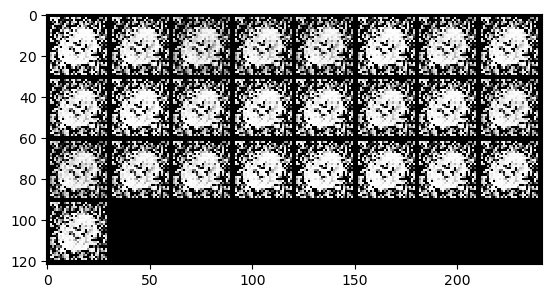

Train Epoch: 0 [0/12665 (0%)]	Loss: 9.962871
Train Epoch: 1 [0/12665 (0%)]	Loss: 0.000000
Train Epoch: 2 [0/12665 (0%)]	Loss: 0.000000
Train Epoch: 3 [0/12665 (0%)]	Loss: 0.000000
Train Epoch: 4 [0/12665 (0%)]	Loss: 0.000000
Test Accuracy of the model on the test images: 99.95272064208984 %
training GAN on experience 1
[1/5]:GAN loss_d: 0.916, loss_g: 1.060
[2/5]:GAN loss_d: 0.799, loss_g: 1.579
[3/5]:GAN loss_d: 0.631, loss_g: 4.180
[4/5]:GAN loss_d: 0.330, loss_g: 6.549


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[5/5]:GAN loss_d: 0.421, loss_g: 9.281


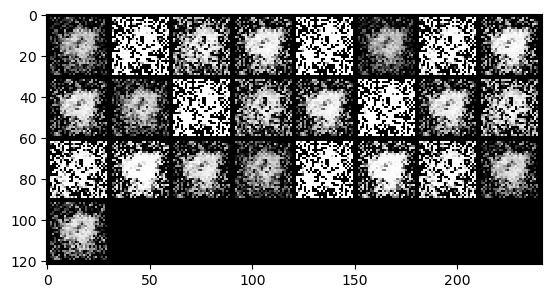

Train Epoch: 0 [0/23695 (0%)]	Loss: 3.929368
Train Epoch: 0 [12800/23695 (54%)]	Loss: 0.087540
Train Epoch: 1 [0/23695 (0%)]	Loss: 0.040660
Train Epoch: 1 [12800/23695 (54%)]	Loss: 0.023568
Train Epoch: 2 [0/23695 (0%)]	Loss: 0.006725
Train Epoch: 2 [12800/23695 (54%)]	Loss: 0.001465
Train Epoch: 3 [0/23695 (0%)]	Loss: 0.004285
Train Epoch: 3 [12800/23695 (54%)]	Loss: 0.000894
Train Epoch: 4 [0/23695 (0%)]	Loss: 0.014821
Train Epoch: 4 [12800/23695 (54%)]	Loss: 0.005726
Test Accuracy of the model on the test images: 49.537261962890625 %
training GAN on experience 2


KeyboardInterrupt: 

In [134]:
%reload_ext autoreload
%autoreload 2
from helper_func import *
from torch.utils.data import ConcatDataset

def get_new_generator_and_discriminator():
    lr = 0.0002
    G = generator(input_size=100, n_class=28*28)
    D = discriminator(input_size=28*28, n_class=1)

    G_optimizer = optim.Adam(G.parameters(), lr=lr)
    D_optimizer = optim.Adam(D.parameters(), lr=lr)

    BCE_loss = nn.BCELoss()
    return G, D, G_optimizer, D_optimizer, BCE_loss

# training parameters
batch_size = 128
#fixed_z_ = torch.randn((batch_size, 100))


#train CL
cl_accuracies = []
for experience in range(5):
    train_dataset, test_dataset = get_datasets(experience, transform=transform)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=True)
    if experience != 0:
        #create new data with GAN
        new_dataset = generate_data(G, model_cl, n_images = 60000*2/10, batch_size = batch_size) # half of the images are generated half are new
        #concatenate with old data
        X = torch.cat((train_dataset.data, new_dataset.data), 0)
        y = torch.cat((train_dataset.targets, new_dataset.targets), 0)
        #create new dataset
        concat_dataset = DS_from_tensors(X, y)
        train_loader = torch.utils.data.DataLoader(concat_dataset, batch_size=batch_size, shuffle=True)

    print('training GAN on experience {}'.format(experience))
    G, D, G_optimizer, D_optimizer, BCE_loss = get_new_generator_and_discriminator()
    G, D, D_losses, G_losses = train_GAN(G, D, train_loader, G_optimizer, D_optimizer, BCE_loss, train_epoch = 300)
    images = generate_images(G, n_images=25).numpy()
    plt.imshow(images.transpose((1, 2, 0)))
    plt.show()

    #CL train
    model_cl = Net()
    cl_optimizer = SGD(model_cl.parameters(), lr=0.001, momentum=0.9)
    cl_criterion = CrossEntropyLoss()
    for epoch in range(3):
        model_cl.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            #wrap data in Variable
            data, target = Variable(data), Variable(target)
            cl_optimizer.zero_grad()
            output = model_cl(data)
            loss = cl_criterion(output, target)
            loss.backward()
            cl_optimizer.step()
            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))
    model_cl.eval()
    accuracy = test_model(model_cl, test_loader)
    cl_accuracies.append(accuracy)

print('cl accuracies: {}'.format(cl_accuracies))

## plots

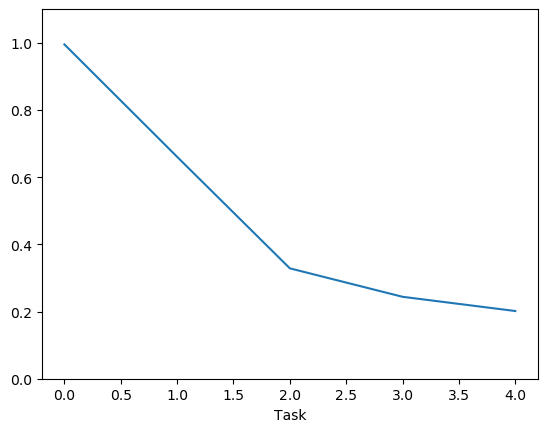

In [70]:
#TODO: use naive and scholar evaluation to plot results

plt.plot(naive_accuracies, label='naive')
plt.plot(cl_accuracies, label='CL')

plt.xlabel('Task')

plt.ylim(0, 1.1)
plt.show()